In [1]:
# version 4
# --------------------------
# use stable BCE loss based on https://github.com/AlexiaJM/RelativisticGAN
# create a baseline ra gan with LS loss using gan framework
# https://github.com/shayneobrien/generative-models
# spectral norm + layer norm for disc
# speactral norm for generator
# gaussian noise in disc layer
# pixelnorm in gen
# minibatch standard dev in disc
# xavier norm init for conv layers
# num_epoch = 690   

In [2]:
COMPUTE_LB = True

In [3]:
import time
kernel_start_time = time.perf_counter()

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from IPython.display import SVG, display

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os, time, glob, shutil
starttime = time.time()

import warnings
warnings.simplefilter("ignore")

from pathlib import Path
import xml.etree.ElementTree as ET # for parsing XML
from PIL import Image # to read images
import glob
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

from argparse import Namespace
import numpy as np
import random
import torch
from torch import nn, optim
import torch.nn.functional as F

import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
import torchvision.utils as vutils

from ignite.contrib.handlers import ProgressBar
from ignite.engine import Engine, Events
from ignite.handlers import ModelCheckpoint, Timer
from ignite.metrics import RunningAverage


In [4]:
args = Namespace(
    seed=123,
    disable_cuda=False,
    device=None,
    debug=False,
    num_workers=4,
    # use this for exp name
    CKPT_PREFIX = 'ra_dcgan_ls_loss',
    exp_name = None,

    ########## Ignite Stuff ###################
    PRINT_FREQ = 600,
    FAKE_IMG_FNAME = 'fake_sample_epoch_{:04d}.png',
    REAL_IMG_FNAME = 'real_sample_epoch_{:04d}.png',
    LOGS_FNAME = 'logs.tsv',
    PLOT_FNAME = 'plot.svg',
    SAMPLES_FNAME = 'samples.svg',
    output_dir = '../output_dir_' + str(time.time()).split('.')[0]+'/',
    alpha = 0.98, # smoothing constant for exponential moving average
    
    ######### Dataset Related #################
    shuffle=True,
    datapath=Path('../input/all-dogs/all-dogs/'),
    root_images=Path("../input/all-dogs/all-dogs"),
    root_annots=Path("../input/annotation/Annotation/"),
    
    ######### Training Params ######################
    num_epochs=2,
    lrD=1e-4,
    lrG=2e-4,
    beta1 = 0.5, # for adam
    batch_size=32,
    weight_decay=0.001,
    log_interval=100,
    num_disc_update=1,
    tune_lr=True,
    lr_tune_range=(-3, -4), # in log-scale
    num_lr_trys=2,

    ######### Model Params #########################
    image_size=64,
    in_channels=3,
    num_feature_maps_gen=64,
    num_feature_maps_disc=64,
    latent_dim=100,
    input_dim=64*64,
    hidden_size=400,    
    dropout_p=0.2,
)
args.lrG = 2 * args.lrD
args.exp_name = args.CKPT_PREFIX + f"_{args.num_epochs}ep_{args.batch_size}bs_{args.num_disc_update}ndisc"
print("="*100)
print(args.exp_name)
print("="*100)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def seed_everything(seed=args.seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

In [ ]:
#####################
### Eval Code
#####################

import numpy as np
import os
import gzip, pickle
import tensorflow as tf
from scipy import linalg
import pathlib
import urllib
import warnings
# from tqdm import tqdm
from PIL import Image

class KernelEvalException(Exception):
    pass

model_params = {
    'Inception': {
        'name': 'Inception', 
        'imsize': 64,
        'output_layer': 'Pretrained_Net/pool_3:0', 
        'input_layer': 'Pretrained_Net/ExpandDims:0',
        'output_shape': 2048,
        'cosine_distance_eps': 0.1
        }
}

def create_model_graph(pth):
    """Creates a graph from saved GraphDef file."""
    # Creates graph from saved graph_def.pb.
    with tf.gfile.FastGFile( pth, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString( f.read())
        _ = tf.import_graph_def( graph_def, name='Pretrained_Net')

def _get_model_layer(sess, model_name):
    # layername = 'Pretrained_Net/final_layer/Mean:0'
    layername = model_params[model_name]['output_layer']
    layer = sess.graph.get_tensor_by_name(layername)
    ops = layer.graph.get_operations()
    for op_idx, op in enumerate(ops):
        for o in op.outputs:
            shape = o.get_shape()
            if shape._dims != []:
              shape = [s.value for s in shape]
              new_shape = []
              for j, s in enumerate(shape):
                if s == 1 and j == 0:
                  new_shape.append(None)
                else:
                  new_shape.append(s)
              o.__dict__['_shape_val'] = tf.TensorShape(new_shape)
    return layer

def get_activations(images, sess, model_name, batch_size=50, verbose=False):
    """Calculates the activations of the pool_3 layer for all images.

    Params:
    -- images      : Numpy array of dimension (n_images, hi, wi, 3). The values
                     must lie between 0 and 256.
    -- sess        : current session
    -- batch_size  : the images numpy array is split into batches with batch size
                     batch_size. A reasonable batch size depends on the disposable hardware.
    -- verbose    : If set to True and parameter out_step is given, the number of calculated
                     batches is reported.
    Returns:
    -- A numpy array of dimension (num images, 2048) that contains the
       activations of the given tensor when feeding inception with the query tensor.
    """

    inception_layer = _get_model_layer(sess, model_name)
    n_images = images.shape[0]
    if batch_size > n_images:
        print("warning: batch size is bigger than the data size. setting batch size to data size")
        batch_size = n_images
    n_batches = n_images//batch_size + 1
    pred_arr = np.empty((n_images,model_params[model_name]['output_shape']))
    for i in tqdm(range(n_batches)):
        if verbose:
            print("\rPropagating batch %d/%d" % (i+1, n_batches), end="", flush=True)
        start = i*batch_size
        if start+batch_size < n_images:
            end = start+batch_size
        else:
            end = n_images
                    
        batch = images[start:end]
        pred = sess.run(inception_layer, {model_params[model_name]['input_layer']: batch})
        pred_arr[start:end] = pred.reshape(-1,model_params[model_name]['output_shape'])
    if verbose:
        print(" done")
    return pred_arr


# def calculate_memorization_distance(features1, features2):
#     neigh = NearestNeighbors(n_neighbors=1, algorithm='kd_tree', metric='euclidean')
#     neigh.fit(features2) 
#     d, _ = neigh.kneighbors(features1, return_distance=True)
#     print('d.shape=',d.shape)
#     return np.mean(d)

def normalize_rows(x: np.ndarray):
    """
    function that normalizes each row of the matrix x to have unit length.

    Args:
     ``x``: A numpy matrix of shape (n, m)

    Returns:
     ``x``: The normalized (by row) numpy matrix.
    """
    return np.nan_to_num(x/np.linalg.norm(x, ord=2, axis=1, keepdims=True))


def cosine_distance(features1, features2):
    # print('rows of zeros in features1 = ',sum(np.sum(features1, axis=1) == 0))
    # print('rows of zeros in features2 = ',sum(np.sum(features2, axis=1) == 0))
    features1_nozero = features1[np.sum(features1, axis=1) != 0]
    features2_nozero = features2[np.sum(features2, axis=1) != 0]
    norm_f1 = normalize_rows(features1_nozero)
    norm_f2 = normalize_rows(features2_nozero)

    d = 1.0-np.abs(np.matmul(norm_f1, norm_f2.T))
    print('d.shape=',d.shape)
    print('np.min(d, axis=1).shape=',np.min(d, axis=1).shape)
    mean_min_d = np.mean(np.min(d, axis=1))
    print('distance=',mean_min_d)
    return mean_min_d


def distance_thresholding(d, eps):
    if d < eps:
        return d
    else:
        return 1

def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
            
    Stable version by Dougal J. Sutherland.

    Params:
    -- mu1 : Numpy array containing the activations of the pool_3 layer of the
             inception net ( like returned by the function 'get_predictions')
             for generated samples.
    -- mu2   : The sample mean over activations of the pool_3 layer, precalcualted
               on an representive data set.
    -- sigma1: The covariance matrix over activations of the pool_3 layer for
               generated samples.
    -- sigma2: The covariance matrix over activations of the pool_3 layer,
               precalcualted on an representive data set.

    Returns:
    --   : The Frechet Distance.
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, "Training and test mean vectors have different lengths"
    assert sigma1.shape == sigma2.shape, "Training and test covariances have different dimensions"

    diff = mu1 - mu2

    # product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = "fid calculation produces singular product; adding %s to diagonal of cov estimates" % eps
        warnings.warn(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        # covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))
    
    # numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError("Imaginary component {}".format(m))
        covmean = covmean.real

    # covmean = tf.linalg.sqrtm(tf.linalg.matmul(sigma1,sigma2))

    print('covmean.shape=',covmean.shape)
    # tr_covmean = tf.linalg.trace(covmean)

    tr_covmean = np.trace(covmean)
    return diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean
    # return diff.dot(diff) + tf.linalg.trace(sigma1) + tf.linalg.trace(sigma2) - 2 * tr_covmean
#-------------------------------------------------------------------------------


def calculate_activation_statistics(images, sess, model_name, batch_size=50, verbose=False):
    """Calculation of the statistics used by the FID.
    Params:
    -- images      : Numpy array of dimension (n_images, hi, wi, 3). The values
                     must lie between 0 and 255.
    -- sess        : current session
    -- batch_size  : the images numpy array is split into batches with batch size
                     batch_size. A reasonable batch size depends on the available hardware.
    -- verbose     : If set to True and parameter out_step is given, the number of calculated
                     batches is reported.
    Returns:
    -- mu    : The mean over samples of the activations of the pool_3 layer of
               the incption model.
    -- sigma : The covariance matrix of the activations of the pool_3 layer of
               the incption model.
    """
    act = get_activations(images, sess, model_name, batch_size, verbose)
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma, act
    
def _handle_path_memorization(path, sess, model_name, is_checksize, is_check_png):
    path = pathlib.Path(path)
    files = list(path.glob('*.jpg')) + list(path.glob('*.png'))
    imsize = model_params[model_name]['imsize']

    # In production we don't resize input images. This is just for demo purpose. 
    x = np.array([np.array(img_read_checks(fn, imsize, is_checksize, imsize, is_check_png)) for fn in files])
    m, s, features = calculate_activation_statistics(x, sess, model_name)
    del x #clean up memory
    return m, s, features

# check for image size
def img_read_checks(filename, resize_to, is_checksize=False, check_imsize = 64, is_check_png = False):
    im = Image.open(str(filename))
    if is_checksize and im.size != (check_imsize,check_imsize):
        raise KernelEvalException('The images are not of size '+str(check_imsize))
    
    if is_check_png and im.format != 'PNG':
        raise KernelEvalException('Only PNG images should be submitted.')

    if resize_to is None:
        return im
    else:
        return im.resize((resize_to,resize_to),Image.ANTIALIAS)

def calculate_kid_given_paths(paths, model_name, model_path, feature_path=None, mm=[], ss=[], ff=[]):
    ''' Calculates the KID of two paths. '''
    tf.reset_default_graph()
    create_model_graph(str(model_path))
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        m1, s1, features1 = _handle_path_memorization(paths[0], sess, model_name, is_checksize = True, is_check_png = True)
        if len(mm) != 0:
            m2 = mm
            s2 = ss
            features2 = ff
        elif feature_path is None:
            m2, s2, features2 = _handle_path_memorization(paths[1], sess, model_name, is_checksize = False, is_check_png = False)
        else:
            with np.load(feature_path) as f:
                m2, s2, features2 = f['m'], f['s'], f['features']

        print('m1,m2 shape=',(m1.shape,m2.shape),'s1,s2=',(s1.shape,s2.shape))
        print('starting calculating FID')
        fid_value = calculate_frechet_distance(m1, s1, m2, s2)
        print('done with FID, starting distance calculation')
        distance = cosine_distance(features1, features2)        
        return fid_value, distance, m2, s2, features2

In [5]:
### All utility functions
def get_bbox(img_path):
    "image path as input and return list of bounding boxes around dogs (could be more than one per image)"
    annotation_basename = os.path.splitext(os.path.basename(img_path))[0]
    annotation_dirname = next(dirname for dirname in os.listdir(args.root_annots) if dirname.startswith(annotation_basename.split('_')[0]))
    annotation_filename = os.path.join(args.root_annots, annotation_dirname, annotation_basename)
    tree = ET.parse(annotation_filename)
    root = tree.getroot()
    objects = root.findall('object')
    bboxes = []
    for o in objects:
        bndbox = o.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        w = np.min((xmax - xmin, ymax - ymin))
        bboxes.append((xmin, ymin, xmin+w, ymin+w))
    return bboxes

def doggo_loader(img_path):
    img = torchvision.datasets.folder.default_loader(img_path) # default loader
    bbox = get_bbox(img_path)[-1]
    return img.crop(bbox)

def clear_output_dir():
    try:
        shutil.rmtree(args.output_dir)
    except FileNotFoundError:
        pass

def check_gen_samples(dataloader, img_list):
    "Plot tile of real and generated images"
    
    real_batch = next(iter(dataloader))
    # Plot the real images
    plt.figure(figsize=(15,15))
    plt.subplot(1,2,1)
    plt.axis("off")
    plt.title("Real Images")
    plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

    # Plot the fake images from the last epoch
    plt.subplot(1,2,2)
    plt.axis("off")
    plt.title("Fake Images")
    plt.imshow(np.transpose(img_list[-1],(1,2,0)))
    plt.show()
    
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.xavier_normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [6]:
class DogDataset(Dataset):
    def __init__(self, img_dir, transform1, transform2=None):
        self.img_dir = img_dir
        self.img_names = os.listdir(img_dir)
        self.transform1 = transform1
        self.transform2 = transform2
        
        self.imgs = []
        for img_name in tqdm(self.img_names):
            img_path = os.path.join(img_dir, img_name)
            img = Image.open(img_path)
            bboxes = get_bbox(img_path)
            
            for bbox in bboxes:
                img_crop = img.crop(bbox)
                self.imgs.append(self.transform1(img_crop))

    def __getitem__(self, index):
        img = self.imgs[index]
        
        if self.transform2 is not None:
            img = self.transform2(img)
        
        return img

    def __len__(self):
        return len(self.imgs)

def get_transforms():
    
    # this normalizes pixel values between [-1,1]
    # https://www.kaggle.com/jesucristo/gan-introduction565419
    # GANHACK #1
    normalize = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    random_transforms = [transforms.ColorJitter(), 
                         transforms.RandomRotation(degrees=3)]
    random_cropper = [torchvision.transforms.CenterCrop(args.image_size), torchvision.transforms.RandomCrop(args.image_size)]


    # First preprocessing of data
    transform1 = transforms.Compose([
        transforms.Resize(args.image_size),
        transforms.CenterCrop(args.image_size),
    ])

    transform2 = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomApply(random_transforms, p=0.4),
        transforms.ToTensor(),
        normalize]) 
    
    return transform1, transform2

transform1, transform2 = get_transforms()
train_data = DogDataset(img_dir=args.root_images,
                        transform1=transform1,
                        transform2=transform2)

dataloader = torch.utils.data.DataLoader(train_data, 
                                         shuffle=True,
                                         batch_size=args.batch_size, 
                                         num_workers=args.num_workers)

100%|██████████| 20579/20579 [02:29<00:00, 137.42it/s]


In [7]:
# ----------------------------------------------------------------------------
# Pixelwise feature vector normalization.
# reference: https://github.com/tkarras/progressive_growing_of_gans/blob/master/networks.py#L120
# ----------------------------------------------------------------------------
class PixelwiseNorm(nn.Module):
    def __init__(self):
        super(PixelwiseNorm, self).__init__()

    def forward(self, x, alpha=1e-8):
        """
        forward pass of the module
        :param x: input activations volume
        :param alpha: small number for numerical stability
        :return: y => pixel normalized activations
        """
        y = x.pow(2.).mean(dim=1, keepdim=True).add(alpha).sqrt()  # [N1HW]
        y = x / y  # normalize the input x volume
        return y
    
class MinibatchStdDev(nn.Module):
    """
    Minibatch standard deviation layer for the discriminator
    """

    def __init__(self):
        """
        derived class constructor
        """
        super(MinibatchStdDev, self).__init__()

    def forward(self, x, alpha=1e-8):
        """
        forward pass of the layer
        :param x: input activation volume
        :param alpha: small number for numerical stability
        :return: y => x appended with standard deviation constant map
        """
        batch_size, _, height, width = x.shape
        # [B x C x H x W] Subtract mean over batch.
        y = x - x.mean(dim=0, keepdim=True)
        # [1 x C x H x W]  Calc standard deviation over batch
        y = torch.sqrt(y.pow(2.).mean(dim=0, keepdim=False) + alpha)

        # [1]  Take average over feature_maps and pixels.
        y = y.mean().view(1, 1, 1, 1)

        # [B x 1 x H x W]  Replicate over group and pixels.
        y = y.repeat(batch_size,1, height, width)

        # [B x C x H x W]  Append as new feature_map.
        y = torch.cat([x, y], 1)
        # return the computed values:
        return y    
    
    
class GaussianNoise(nn.Module):
    """Gaussian noise regularizer.

    Args:
        sigma (float, optional): relative standard deviation used to generate the
            noise. Relative means that it will be multiplied by the magnitude of
            the value your are adding the noise to. This means that sigma can be
            the same regardless of the scale of the vector.
        is_relative_detach (bool, optional): whether to detach the variable before
            computing the scale of the noise. If `False` then the scale of the noise
            won't be seen as a constant but something to optimize: this will bias the
            network to generate vectors with smaller values.
    """

    def __init__(self, sigma=0.1, is_relative_detach=True):
        super().__init__()
        self.sigma = sigma
        self.is_relative_detach = is_relative_detach
        self.noise = torch.tensor(0.).to(device)

    def forward(self, x):
        if self.training and self.sigma != 0:
            scale = self.sigma * x.detach() if self.is_relative_detach else self.sigma * x
            sampled_noise = self.noise.repeat(*x.size()).normal_() * scale
            x = x + sampled_noise
        return x 


In [8]:
## All Model Related

class Net(nn.Module):
    """ 
    A base class for both generator and the discriminator.
    Provides a common weight initialization scheme.
    """
    def weights_init(self):
        for m in self.modules():
            classname = m.__class__.__name__

            if 'Conv' in classname:
                pass
#                 m.weight.data.xavier_normal_(0.0, 0.02)
#                 m.weight.data.normal_(0.0, 0.02)

            elif 'BatchNorm' in classname:
                pass
#                 m.weight.data.normal_(1.0, 0.02)
#                 m.bias.data.fill_(0)

    def forward(self, x):
        return x

class Generator(Net):
    def __init__(self):
        super(Generator, self).__init__()
        
        def conv_block(n_input, n_output, k_size=4, stride=2, padding=0):
            block = [
                nn.utils.spectral_norm(nn.ConvTranspose2d(n_input, n_output, 
                                                          k_size, stride, padding, bias=False)),
                nn.BatchNorm2d(n_output),
                nn.ReLU(inplace=True),                
            ]
            return block
        
        self.project = nn.Sequential(
            nn.Linear(args.latent_dim, 256 * 4 * 4),
            nn.BatchNorm1d(256 * 4 * 4),
            nn.ReLU(inplace=True),
        )
        self.main = nn.Sequential(
            *conv_block(args.latent_dim, args.num_feature_maps_gen * 8, 4, 1, 0),
            # state size. (args.num_feature_maps_gen * 8) x 4 x 4
            *conv_block(args.num_feature_maps_gen * 8, args.num_feature_maps_gen * 4, 4, 2, 1),
            # state size. (args.num_feature_maps_gen*4) x 8 x 8
            *conv_block(args.num_feature_maps_gen * 4, args.num_feature_maps_gen * 2, 4, 2, 1),
            # state size. (args.num_feature_maps_gen*2) x 16 x 16
            *conv_block(args.num_feature_maps_gen * 2, args.num_feature_maps_gen * 1, 4, 2, 1),
            # state size. (args.num_feature_maps_gen) x 32 x 32
            nn.ConvTranspose2d( args.num_feature_maps_gen, args.in_channels, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (args.in_channels) x 64 x 64
        )
        self.weights_init()

    def forward(self, input):
        return self.main(input)

    
class Discriminator(Net):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.gnoise = GaussianNoise()
        layer1 = []
        layer2 = []
        layer3 = []
        last = []

        layer1.append(nn.utils.spectral_norm(nn.Conv2d(args.in_channels, 
                                                       args.num_feature_maps_disc, 
                                                       4, 2, 1, bias=False)))
        layer1.append(nn.LeakyReLU(0.1))

        curr_dim = args.num_feature_maps_disc

        layer2.append(nn.utils.spectral_norm(nn.Conv2d(curr_dim, curr_dim * 2, 4, 2, 1)))
        layer2.append(nn.LeakyReLU(0.1))
        curr_dim = curr_dim * 2

        layer3.append(nn.utils.spectral_norm(nn.Conv2d(curr_dim, curr_dim * 2, 4, 2, 1)))
        layer3.append(nn.LeakyReLU(0.1))
        curr_dim = curr_dim * 2

        layer4 = []
        layer4.append(nn.utils.spectral_norm(nn.Conv2d(curr_dim, curr_dim * 2, 4, 2, 1)))
        layer4.append(nn.LeakyReLU(0.1))
        curr_dim = curr_dim*2
        
        self.l1 = nn.Sequential(*layer1)
        self.l2 = nn.Sequential(*layer2)
        self.l3 = nn.Sequential(*layer3)
        self.l4 = nn.Sequential(*layer4)
        self.batch_discriminator = MinibatchStdDev()
        
        last.append(nn.Conv2d(curr_dim + 1, 1, 4, 1, 0, bias=False))
        self.last = nn.Sequential(*last)
        
        self.weights_init()

    def forward(self, x):
        x = self.gnoise(x)
        out = self.l1(x)
        out = self.l2(out)
        out = self.l3(out)
        out = self.l4(out)
        out = self.batch_discriminator(out)
        out = self.last(out)
        
        return out.squeeze()

In [ ]:
def run_trainer(lrD=args.lrD, lrG=args.lrG, be_succint=True):
    if be_succint: args.PRINT_FREQ = 1000
        
    netG = Generator().to(device)
    netD = Discriminator().to(device)

    weights_init(netG)
    weights_init(netD)
    print("Generator parameters:    ", sum(p.numel() for p in netG.parameters() if p.requires_grad))
    print("Discriminator parameters:", sum(p.numel() for p in netD.parameters() if p.requires_grad))

    fixed_noise = torch.randn(64, args.latent_dim, 1, 1, device=device)

    # Establish convention for real and fake labels during training
    real_label = 0.98
    fake_label = 0.

    BCE_stable = nn.BCEWithLogitsLoss()
    optimizerD = optim.Adam(netD.parameters(), lr=lrD, betas=(args.beta1, 0.999))
    optimizerG = optim.Adam(netG.parameters(), lr=lrG, betas=(args.beta1, 0.999))

    def step(engine, batch):
        def train_D(images, real_label=1, fake_label=0):
            """
            Run 1 step of training for discriminator
            Input:
                images: batch of images (reshaped to [batch_size, -1])
            Output:
                D_loss: non-saturing loss for discriminator,
                -E[log( sigmoid(D(x) - E[D(G(z))]) )]
                  - E[log(1 - sigmoid(D(G(z)) - E[D(x)]))]
            """
            noise = torch.randn(args.batch_size, args.latent_dim, 1, 1, device=device)
            G_output = netG(noise)

            fake_labels = torch.full((args.batch_size,), fake_label, device=device)
            real_labels = torch.full((args.batch_size,), real_label, device=device)

            # classify the generated and real batch images
            Dx_score = netD(images) # D(x)
            DG_score = netD(G_output) # D(G(z))

            # Compute RA D loss
            D_loss = (BCE_stable(Dx_score - torch.mean(DG_score), real_labels) + BCE_stable(DG_score - torch.mean(Dx_score), fake_labels))/2

            return D_loss, F.sigmoid(Dx_score).mean().item(), F.sigmoid(DG_score).mean().item()

        def train_G(images, real_label=1, fake_label=0):
            """ Run 1 step of training for generator
                Input:
                    images: batch of images reshaped to [batch_size, -1]
                Output:
                    G_loss: non-saturating loss for how well G(z) fools D,
                    -E[log(sigmoid(D(G(z))-E[D(x)]))]
                        -E[log(1-sigmoid(D(x)-E[D(G(z))]))]
            """
            noise = torch.randn(args.batch_size, args.latent_dim, 1, 1, device=device)
            G_output = netG(noise) # G(z)

            fake_labels = torch.full((args.batch_size,), fake_label, device=device)
            real_labels = torch.full((args.batch_size,), real_label, device=device)

            Dx_score = netD(images) # D(x)
            DG_score = netD(G_output) # D(G(z))

            # Compute RA L2 loss for G                  
            G_loss = (BCE_stable(Dx_score - torch.mean(DG_score), fake_labels) + BCE_stable(DG_score - torch.mean(Dx_score), real_labels))/2

            return G_loss, F.sigmoid(DG_score).mean().item()

        images = batch.to(device)
        args.batch_size = images.size(0)
        D_step_loss = []
        for _ in range(args.num_disc_update):
            netD.zero_grad()

            D_loss, Dx_score, DG_score1 = train_D(images)
            D_loss.backward()
            optimizerD.step()
            D_step_loss.append(D_loss.item())

        # update G
        netG.zero_grad()

        G_loss, DG_score2 = train_G(images)
        G_loss.backward()
        optimizerG.step()

        return {
                'D_loss': np.mean(D_step_loss),
                'G_loss': G_loss.item(),
                'Dx_score': Dx_score,
                'DG_score1': DG_score1,
                'DG_score2': DG_score2
        }    

    clear_output_dir()

    # ignite objects
    trainer = Engine(step)
    checkpoint_handler = ModelCheckpoint(args.output_dir, args.CKPT_PREFIX, save_interval=1, n_saved=10, require_empty=False)
    timer = Timer(average=True)

    # attach running average metrics
    monitoring_metrics = ['D_loss', 'G_loss', 'Dx_score', 'DG_score1', 'DG_score2']
    RunningAverage(alpha=args.alpha, output_transform=lambda x: x['D_loss']).attach(trainer, 'D_loss')
    RunningAverage(alpha=args.alpha, output_transform=lambda x: x['G_loss']).attach(trainer, 'G_loss')
    RunningAverage(alpha=args.alpha, output_transform=lambda x: x['Dx_score']).attach(trainer, 'Dx_score')
    RunningAverage(alpha=args.alpha, output_transform=lambda x: x['DG_score1']).attach(trainer, 'DG_score1')
    RunningAverage(alpha=args.alpha, output_transform=lambda x: x['DG_score2']).attach(trainer, 'DG_score2')

    # attach progress bar
    pbar = ProgressBar()
    pbar.attach(trainer, metric_names=monitoring_metrics)

    # adding handlers using `trainer.on` decorator API
    @trainer.on(Events.ITERATION_COMPLETED)
    def print_logs(engine):
        if (engine.state.iteration - 1) % args.PRINT_FREQ == 0:
            fname = os.path.join(args.output_dir, args.LOGS_FNAME)
            columns = ["iteration", ] + list(engine.state.metrics.keys())
            values = [str(engine.state.iteration), ] + \
                     [str(round(value, 5)) for value in engine.state.metrics.values()]
            with open(fname, 'a') as f:
                if f.tell() == 0:
                    print('\t'.join(columns), file=f)
                print('\t'.join(values), file=f)

            message = '[{epoch}/{max_epoch}][{i}/{max_i}]'.format(epoch=engine.state.epoch,
                                                                  max_epoch=args.num_epochs,
                                                                  i=(engine.state.iteration % len(dataloader)),
                                                                  max_i=len(dataloader))
            for name, value in zip(columns, values):
                message += ' | {name}: {value}'.format(name=name, value=value)
            pbar.log_message(message)

    @trainer.on(Events.EPOCH_COMPLETED)
    def save_fake_example(engine):
        fake = netG(fixed_noise).detach().cpu()
        path = os.path.join(args.output_dir, args.FAKE_IMG_FNAME.format(engine.state.epoch))
        vutils.save_image((fake+1.)/2., path, normalize=True)

    @trainer.on(Events.EPOCH_COMPLETED)
    def save_real_example(engine):
        img = engine.state.batch
        path = os.path.join(args.output_dir, args.REAL_IMG_FNAME.format(engine.state.epoch))
        vutils.save_image(img, path, normalize=True)

    @trainer.on(Events.EPOCH_COMPLETED)
    def display_images(engine):
        if engine.state.epoch % 10 == 0:
            display(Image.open(os.path.join(args.output_dir, args.REAL_IMG_FNAME.format(engine.state.epoch))))
            display(Image.open(os.path.join(args.output_dir, args.FAKE_IMG_FNAME.format(engine.state.epoch))))    

    # adding handlers using `trainer.add_event_handler` method API
    trainer.add_event_handler(event_name=Events.EPOCH_COMPLETED, 
                              handler=checkpoint_handler,
                              to_save={
                                  'netG': netG,
                                  'netD': netD
                              })

    # automatically adding handlers via a special `attach` method of `Timer` handler
    timer.attach(trainer, 
                 start=Events.EPOCH_STARTED, 
                 resume=Events.EPOCH_STARTED,
                 pause=Events.EPOCH_COMPLETED, 
                 step=Events.EPOCH_COMPLETED)

    @trainer.on(Events.EPOCH_COMPLETED)
    def print_times(engine):
        pbar.log_message(f'Epoch {engine.state.epoch} done. Time per epoch: {timer.value()/60:.3f}[min]')
        timer.reset()

    @trainer.on(Events.EPOCH_COMPLETED)
    def create_plots(engine):
        try:
            import matplotlib as mpl
            mpl.use('agg')

            import numpy as np
            import pandas as pd
            import matplotlib.pyplot as plt

        except ImportError:
            warnings.warn('Loss plots will not be generated -- pandas or matplotlib not found')

        else:
            df = pd.read_csv(os.path.join(args.output_dir, args.LOGS_FNAME), delimiter='\t', index_col='iteration')
            _ = df.loc[:, list(engine.state.metrics.keys())].plot(subplots=True, figsize=(10, 10))
            _ = plt.xlabel('Iteration number')
            fig = plt.gcf()
            path = os.path.join(args.output_dir, args.PLOT_FNAME)
            fig.savefig(path)

    @trainer.on(Events.EPOCH_STARTED)
    def handle_timeout(engine):
        if time.perf_counter() - kernel_start_time > 31000:
            print("Time limit reached! Stopping kernel!")
            engine.terminate()

            create_plots(engine)
            checkpoint_handler(engine, {
                'netG_exception': netG,
                'netD_exception': netD
            })

    @trainer.on(Events.EXCEPTION_RAISED)
    def handle_exception(engine, e):
        if isinstance(e, KeyboardInterrupt) and (engine.state.iteration > 1):
            engine.terminate()
            warnings.warn('KeyboardInterrupt caught. Exiting gracefully.')

            create_plots(engine)
            checkpoint_handler(engine, {
                'netG_exception': netG,
                'netD_exception': netD
            })

        else:
            raise e

    trainer.run(dataloader, args.num_epochs)
    
    output_images_dir = '/scratch/work/kumary1/dogs/output_images_' + str(time.time()).split('.')[0]
    if not os.path.exists(output_images_dir):
        os.mkdir(output_images_dir)
    im_batch_size = 50
    n_images=10000
    for i_batch in range(0, n_images, im_batch_size):
        gen_z = torch.randn(im_batch_size, args.latent_dim, 1, 1, device=device)
        gen_images = (netG(gen_z)+1.)/2. # denormalize
        images = gen_images.to("cpu").clone().detach()
        images = images.numpy().transpose(0, 2, 3, 1)
        for i_image in range(gen_images.size(0)):
            save_image(gen_images[i_image, :, :, :], os.path.join(output_images_dir, f'image_{i_batch+i_image:05d}.png'))


    import shutil
    shutil.make_archive('images', 'zip', output_images_dir)
    
    return trainer, netG, netD

def compute_fid(lrD):
    if COMPUTE_LB and args.tune_lr:
        eval_start = time.time()
        # UNCOMPRESS OUR IMGAES
        shutil.unpack_archive('images.zip', extract_dir='../tmp/images2')
    #     with zipfile.ZipFile("./images.zip","r") as z:
    #         z.extractall("../tmp/images2/")

        # COMPUTE LB SCORE
        m2 = []; s2 =[]; f2 = []
        user_images_unzipped_path = '../tmp/images2/'
        images_path = [user_images_unzipped_path,'/scratch/work/kumary1/dogs/all-dogs/']
        public_path = '../input/classify_image_graph_def.pb'

        fid_epsilon = 10e-15

        fid_value_public, distance_public, m2, s2, f2 = calculate_kid_given_paths(images_path, 'Inception', public_path, mm=m2, ss=s2, ff=f2)
        distance_public = distance_thresholding(distance_public, model_params['Inception']['cosine_distance_eps'])
        print("="*90)
        print(f"lrD = {lrD}")
        print("FID_public: ", fid_value_public, "distance_public: ", distance_public, "multiplied_public: ",
                fid_value_public /(distance_public + fid_epsilon))
        print("="*90)
        # REMOVE FILES TO PREVENT KERNEL ERROR OF TOO MANY FILES
        ! rm -r ../tmp
        print(f"Eval done in {(time.time() - eval_start)/60:.4f} minutes.")

In [ ]:
if args.tune_lr:
    for i in range(args.num_lr_trys):
        args.lrD = 10**(-random.randint(-3, -2))
        args.lrG = 2 * args.lrD
        print("="*90)
        print(f"lrD: {args.lrD} \t lrG: {args.lrG}")
        trainer, netG, netD = run_trainer(lrD, lrG)    
        compute_fid(lrD)

In [9]:
if not args.tune_lr:
    trainer, netG, netD = run_trainer(args.lrD, args.lrG, be_succint=False)

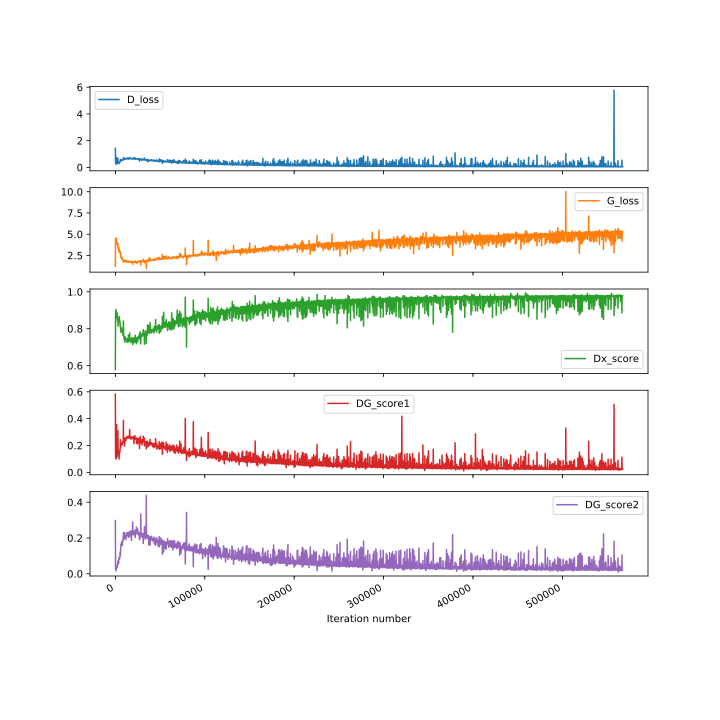

In [11]:
# analysize logs
# display(SVG("../output_dir/plot.svg"))

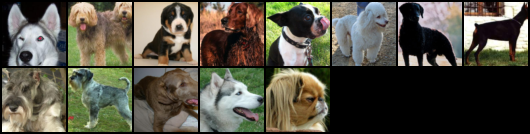

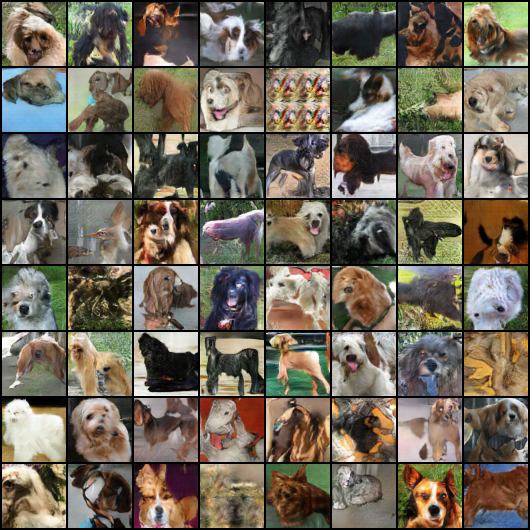

In [12]:
# display(Image.open(os.path.join(args.output_dir, args.REAL_IMG_FNAME.format(args.num_epochs-1))))
# display(Image.open(os.path.join(args.output_dir, args.FAKE_IMG_FNAME.format(args.num_epochs-1))))

'/kaggle/working/images.zip'

In [15]:
if COMPUTE_LB and not args.tune_lr:
    eval_start = time.time()
    # UNCOMPRESS OUR IMGAES
    shutil.unpack_archive('images.zip', extract_dir='../tmp/images2')
#     with zipfile.ZipFile("./images.zip","r") as z:
#         z.extractall("../tmp/images2/")

    # COMPUTE LB SCORE
    m2 = []; s2 =[]; f2 = []
    user_images_unzipped_path = '../tmp/images2/'
    images_path = [user_images_unzipped_path,'/scratch/work/kumary1/dogs/all-dogs/']
    public_path = '../input/classify_image_graph_def.pb'

    fid_epsilon = 10e-15

    fid_value_public, distance_public, m2, s2, f2 = calculate_kid_given_paths(images_path, 'Inception', public_path, mm=m2, ss=s2, ff=f2)
    distance_public = distance_thresholding(distance_public, model_params['Inception']['cosine_distance_eps'])
    print("="*90)
    print(f"lrD = {args.lrD}")
    print("FID_public: ", fid_value_public, "distance_public: ", distance_public, "multiplied_public: ",
            fid_value_public /(distance_public + fid_epsilon))
    print("="*90)
    # REMOVE FILES TO PREVENT KERNEL ERROR OF TOO MANY FILES
    ! rm -r ../tmp
    print(f"Eval done in {(time.time() - eval_start)/60:.4f} minutes.")    

In [16]:
print(f"Done in {(time.time() - starttime)/60:.4f} minutes.")

Done in 526.7711 minutes.
